# Analyzing Trump Tweets

In this notebook, I will attempt to perform some analysis on Donald Trump's tweets. I hope to learn how to access Twitter's API to scrape tweet data, as well as some basic natural language processing.

In [2]:
import tweepy
from tweepy import OAuthHandler
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib
import matplotlib.pyplot as plt
import itertools
import pandas as pd

/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
#set up access to Twitter API 
consumer_key = 'SsPIsxuj0sGUbSiSPVVUhqY9b'
consumer_secret = 'vQi4cbKyYAnjYjuMFZ79g9i0MJFrgUofkZ7UfDyS2MFMNMYWsU'
access_token = '868623131799412736-cyBXAkrU6fSWWWaIT97st2DUiyBCQvW'
access_secret = 'Ei2jdovTshu9DVW7lbUsGv8CcbdrFKjC7meUSzBDHDHtb'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

Since the Twitter API only returns tweets of one page at a time, we will have to iterate through the pages to grab the entire timeline. This code is adapted from https://gist.github.com/yanofsky/5436496

In [4]:
#initialize a list to hold all the tweepy Tweets
alltweets = []

#make initial request for most recent tweets (200 is the maximum allowed count)
new_tweets = api.user_timeline(screen_name = 'realDonaldTrump',count=200,include_rts = True)

#save most recent tweets
alltweets.extend(new_tweets)

#save the id of the oldest tweet less one
oldest = alltweets[-1].id - 1

#keep grabbing tweets until there are no tweets left to grab
while len(new_tweets) > 0:
    print("getting tweets before %s" % (oldest))

    #all subsiquent requests use the max_id param to prevent duplicates
    new_tweets = api.user_timeline(screen_name = 'realDonaldTrump',count=200,max_id=oldest,include_rts = False)

    #save most recent tweets
    alltweets.extend(new_tweets)

    #update the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    print("...%s tweets downloaded so far" % (len(alltweets)))


getting tweets before 886635676787232767
...375 tweets downloaded so far
getting tweets before 877879361130688511
...547 tweets downloaded so far
getting tweets before 864207293289771011
...730 tweets downloaded so far
getting tweets before 850722694958075904
...916 tweets downloaded so far
getting tweets before 833435244451753983
...1114 tweets downloaded so far
getting tweets before 821705440178348032
...1301 tweets downloaded so far
getting tweets before 808638507161882623
...1489 tweets downloaded so far
getting tweets before 795019500345233407
...1681 tweets downloaded so far
getting tweets before 789224624320028671
...1863 tweets downloaded so far
getting tweets before 785913754194104319
...2024 tweets downloaded so far
getting tweets before 781784161044553727
...2205 tweets downloaded so far
getting tweets before 774435151975747583
...2397 tweets downloaded so far
getting tweets before 766616610975182847
...2585 tweets downloaded so far
getting tweets before 759185456818860031
.

Great, so now we have a list of all the tweet objects. Each tweet object has a wealth of associated metadata, which we can explore:

In [5]:
print(dir(alltweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'extended_entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweeted_status', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


At this point, I really want to use NLTK's VADER sentiment analysis package to calculate a sentiment score for each tweet. The algorithm calculates a compound "polarity" score for each tweet - that is, it analyzes words that are commonly associated with positive or negative sentiments, and assigns a weighted average of sorts to the tweet. It might be interesting to plot the sentiment of each tweet over time and see if we can find any interesting results. 

Since for now the only information we need is the tweet text itself, let's create a dictionary of the tweet content with its tweet ID so we can reference other metadata later.

In [6]:
tweetcontent = {}
tweetdates = {}
for tweet in alltweets: 
    tweetcontent[tweet.id] = tweet.text
    tweetdates[tweet.id] = tweet.created_at


Cool, now we have a dictionary of tweet IDs and the relevant tweet content. Let's throw this into VADER and see what we find...

In [7]:
sid = SentimentIntensityAnalyzer()
sentiment_scores= {}
for key in tweetcontent:
    ss = sid.polarity_scores(tweetcontent[key])
    sentiment_scores[key] = ss['compound'] #save the compound scores into a dictionary 

Now we have the compound sentiment scores for all of the tweets in the corpus. Let's see if we can plot these over time and see if anything stands out. 


In [8]:
#combine the dictionaries 
dates_sentiment = {}
for key in tweetcontent:
    dates_sentiment[key] = [tweetdates[key], sentiment_scores[key]]
        

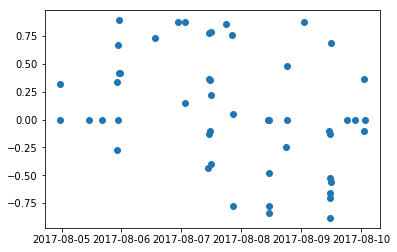

In [9]:
#extract the vectors 
dates = []
scores = []
for key in dates_sentiment: 
    dates.append(dates_sentiment[key][0])
    scores.append(dates_sentiment[key][1])

#convert dates to Matplotlib format
#dates = matplotlib.dates.date2num(dates)
plt.plot_date(dates[0:50], scores[0:50])
plt.show()

Plotting the tweet scores on their own doesn't seem to reveal anything enlightening. Let's see how else we can summarize the scores another way. Let's plot the average score per month to consolidate some of the data.

In [10]:
df = pd.DataFrame.from_dict(dates_sentiment, orient='index')
d = df.groupby([(df[0].dt.year),(df[0].dt.month)])[1].mean().to_dict()
print("Year, Month" + "\t" + "Average Tweet Sentiment")
d

Year, Month	Average Tweet Sentiment


{(2016, 6): 0.10638260869565218,
 (2016, 7): 0.014003966005665724,
 (2016, 8): 0.082540671641791019,
 (2016, 9): 0.23030073529411743,
 (2016, 10): 0.12231531914893605,
 (2016, 11): 0.28088938547486036,
 (2016, 12): 0.26409465648854952,
 (2017, 1): 0.08974207920792078,
 (2017, 2): 0.02550136986301367,
 (2017, 3): 0.26158854961832062,
 (2017, 4): 0.20616204379562042,
 (2017, 5): 0.19147777777777783,
 (2017, 6): 0.11944393063583812,
 (2017, 7): 0.2369951965065501,
 (2017, 8): 0.20757037037037029}

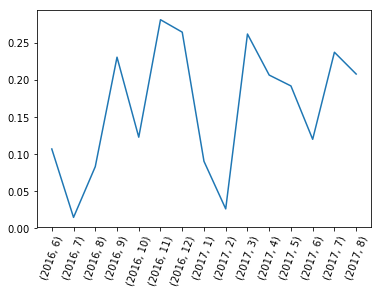

In [29]:
dates = range(0, len(d.keys()))
scores = list(d.values())
plt.plot(dates, scores)
labels = list(d.keys())
plt.xticks(dates, labels, rotation = 70)
plt.show()

 As we can see, Tweet sentiment peaks around election time (understandably!) and plummets post-election. Pretty interesting to see. In later notebooks I want to expand on this data and plot some of the geographic results. Stay tuned.